In [1]:
!pip install matplotlib 

In [2]:
#importing the requisite libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [25]:
image_path = r"D:\Projects\Lane-detection\Lane-Detection\Images\test_image.jpg"
image = cv2.imread(image_path) #converts the image into multidimensional numpy array
cv2.imshow('result', image)
cv2.waitKey(0)
#plt.imshow(image)

-1

In [26]:
 #converting image to grayscale
copy_image = np.copy(image)
gray = cv2.cvtColor(copy_image, cv2.COLOR_RGB2GRAY)
cv2.imshow('result', gray)
cv2.waitKey(0)

-1

In [27]:
#applying gaussian blur
blur_image = cv2.GaussianBlur(gray, (5,5), 0)
cv2.imshow('result', blur_image)
cv2.waitKey(0)


-1

In [28]:

#applying canny edge function
c = cv2.Canny(blur_image, 50,150)
cv2.imshow('result', c)
cv2.waitKey(0)

-1

In [29]:
copy_image = np.copy(image)

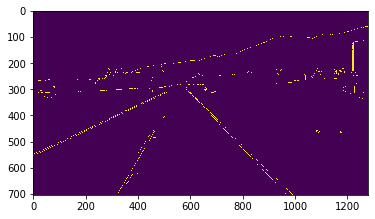

In [30]:
#canny function will contain all the above changes applied on the image
def canny(image):
    gray = cv2.cvtColor(copy_image, cv2.COLOR_RGB2GRAY) #original image
    blur_image = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur_image, 50,150)
    return canny

plt.imshow(canny(copy_image))


    
    

Thus we got the image that is grayscaled, gaussiun blurred and applied on with canny algorithm. 


In [31]:
c1 = canny(copy_image) #making an array of image applied with canny edge function

In [32]:

#finding the region of interest i.e. the region we want to work on
def region_of_int(image):
    height = image.shape[0] #assigning the row of the image shape as height variable
    #defining the coordinates of the triangular region of our interest
    polygons = np.array([
        [(200,height), (1100, height), (550, 250)]
    ])
    #creating an array of same shape as triangle obtained, but containing zeroes only,tracing it on black pixels  
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)#filling the traced polygon with white
    return mask
    
cv2.imshow("result", region_of_int(c1))
cv2.waitKey(0)
    
    

-1

In [33]:
#applying bitwise and on the canny edge image and traced image
def region_of_int(image):
    height = image.shape[0] #assigning the row of the image shape as height variable
    #defining the coordinates of the triangular region of our interest
    polygons = np.array([
        [(200,height), (1100, height), (550, 250)]
    ])
    #creating an array of same shape as triangle obtained, but containing zeroes only and tracing it on black pixels  
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask) #masking by applying bitwise and func
    return masked_image



In [34]:
cropped_image = region_of_int(c1)
cv2.imshow("result", cropped_image)
cv2.waitKey(0)

-1

In [35]:
#applying Hough transform 
#creating the 2-d hough array, second and third argument define the grid precision pixels and radian, and fourth arg describes threshold of int. 
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength = 40, maxLineGap = 5)

def display_lines(image, lines):
    line_image = np.zeros_like(image)#creating an array of same pixels as original img
    if lines is not None: 
       for line in lines:
            x1, y1, x2, y2= line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image 
    
    



In [36]:
line_image = display_lines(copy_image, lines)
cv2.imshow("result", line_image)
cv2.waitKey(0)

-1

In [37]:
#take sum of color image(copy_image) with line image with weights, i.e merging the black and original image
combo_image = cv2.addWeighted(copy_image, 0.8, line_image, 1, 1)
cv2.imshow("result", combo_image)
cv2.waitKey(0)

-1

In [38]:
#optimization 

#the coordinates for the averaged out single line
def make_coord(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5)) #till 3/5th of the lenght
    x1 = int((y1 - intercept)/slope) #from basic line formula
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])
  


#average out the slope of multiple lines and make one line
def average_slope_int(image, lines):
    left_fit= []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2= line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1) #fit a first deg polynomial in the given coordinates and return a vector of slope and y intercept
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else: 
            right_fit.append((slope, intercept))
    #averaging out all the slope values we got in each fit
    left_fit_avg = np.average(left_fit, axis = 0)
    right_fit_avg = np.average(right_fit, axis = 0)
    left_line = make_coord(image, left_fit_avg)
    right_line = make_coord(image, right_fit_avg)
    return np.array([left_line, right_line])
            

In [39]:
averaged_lines = average_slope_int(copy_image, lines)
line_image = display_lines(copy_image, averaged_lines)
cv2.imshow("result", line_image)
cv2.waitKey(0)



-1

In [40]:
combo_image = cv2.addWeighted(copy_image, 0.8, line_image, 1, 1)
cv2.imshow("result", combo_image)
cv2.waitKey(0)

-1

In [47]:
#code for video input lane line detection
capture = cv2.VideoCapture(r"D:\Projects\Lane-detection\Lane-Detection\test2.mp4")
while(capture.isOpened()):
    ret, frame = capture.read()
    if ret == True:
        c1 = canny(frame)
        cropped_image = region_of_int(c1)
        lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40,maxLineGap=5)
        averaged_lines = average_slope_int(frame, lines)
        line_image = display_lines(frame, averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
        cv2.imshow("result", combo_image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    else:
        break
capture.release()
cv2.destroyAllWindows()